In [1]:
import random
import math
import copy
import numpy as np

In [2]:
MIN_DIST = 3.4

def dist(p1, p2):
    l = []
    for d1, d2 in zip(p1, p2):
        dd = d2-d1
        if dd > 9.0:
            dd -= 18.0
        if dd <= -9.0:
            dd += 18.0
        l.append(dd)

    s = 0
    for i in l:
        s += i**2
    s = math.sqrt(s)
    
    if s < MIN_DIST:
        return False
    return True

def getDist(p1, p2):
    l = []
    for d1, d2 in zip(p1, p2):
        dd = d2-d1
        if dd > 9.0:
            dd -= 18.0
        if dd <= -9.0:
            dd += 18.0
        l.append(dd)

    s = 0
    for i in l:
        s += i**2
    s = math.sqrt(s)
    return s

def GenerateInitial(N, L):
    current = 0
    points = []

    while current != N:
        x = random.uniform(0, L)
        y = random.uniform(0, L)
        z = random.uniform(0, L)

        possible = True
        for i in points:
            possible = dist(i, (x, y, z))
            if not possible:
                break
        if possible:
            points.append((x, y, z))
            current += 1
            print(f"{current}")

    content = "%d\n\n" % (N)
    for i in points:
        content += "C\t%f\t%f\t%f\n" % i

    for i in range(len(points)):
        for j in range(len(points)):
            if i != j and not dist(points[i], points[j]):
                print(getDist(points[i], points[j]), points[i], points[j])
                print("Invalid")


    f = open("initial.xyz", "w")
    f.write(content)
    f.close()
    return points

def readConfig(f="initial.xyz"):
    f = open(f, "r")
    lines = f.readlines()
    points = []
    for line in lines:
        line = line[:-1]
        line = line.split('\t')
        if len(line) == 4:
            points.append((float(line[1]), float(line[2]), float(line[3])))
    return points

In [3]:
config = readConfig()

In [4]:
def checkConfig(points):
    for p1 in points:
        for p2 in points:
            if p1 == p2:
                continue
            if getDist(p1, p2) < MIN_DIST:
                return False
    return True

def calculatePotential(points):
    epsilon = 0.238
    sigma = 3.4
    energy = 0
    for p1 in points:
        for p2 in points:
            if p1 == p2:
                continue
            r = getDist(p1, p2)
            energy += 4*epsilon * ((sigma/r)**12 - (sigma/r)**6)
    return energy/2

In [5]:
curEnergy = calculatePotential(config)
print(f"Potential energy of the initial configuration: {curEnergy}")

Potential energy of the initial configuration: -124.65301605762043


In [6]:
def neighbor(points):
    newPoints = []
    for point in points:
        x, y, z = point
        x += random.uniform(-0.01, 0.01)
        y += random.uniform(-0.01, 0.01)
        z += random.uniform(-0.01, 0.01)
        newPoints.append((x, y, z))
    return newPoints


In [7]:
from tqdm import tqdm
for i in tqdm(range(0, 10000)):
    newConfig = neighbor(config)
    eNew = calculatePotential(newConfig)
    e = calculatePotential(config)
    if eNew < e and checkConfig(newConfig):
        config = newConfig

print(f"Minimized energy: {calculatePotential(config)}")

100%|██████████| 10000/10000 [06:54<00:00, 24.10it/s]

Minimized energy: -148.533255072374


In [8]:
content = "%d\n\n" % (108)
for i in config:
    content += "C\t%f\t%f\t%f\n" % i
f = open("minConfig.xyz", "w")
f.write(content)
f.close()

In [9]:
%load_ext cython
config = readConfig("minConfig.xyz")
nconfig = copy.deepcopy(config)

In [10]:
%%cython
from tqdm import tqdm
cimport numpy as np
cimport cython
from libc.math cimport sqrt, pow

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef cy_getDist(p1, p2):
    cdef float x = p1[0] - p2[0]
    cdef float y = p1[1] - p2[1]
    cdef float z = p1[2] - p2[2]
    if x > 9.0:
        x -= 18.0
    if x <= -9.0:
        x += 18.0
    if y > 9.0:
        y -= 18.0
    if y <= -9.0:
        y += 18.0 
    if z > 9.0:
        z -= 18.0
    if z < -9.0:
        z += 18.0

    cdef float s = pow(x,2) + pow(y,2) + pow(z,2)

    s = sqrt(s)

    return s

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef cy_calculatePotential(points):
    cdef float epsilon = 0.238
    cdef float sigma = 3.4
    cdef float energy = 0
    cdef float r = 0
    cdef int i, j
    for i  in range(108):
        for j in range(i):
            r = cy_getDist(points[i], points[j])
            energy += 4*epsilon * (pow((sigma/r), 12) - pow((sigma/r),6))
    return energy

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef cy_computeHessian(nconfig):
    cdef int i, j
    hessian = [[0 for i in range(324)] for j in range(324)]
    cdef float d = 0.001
    cdef float dd = 0
    cdef float[3] p, p1, p2
    cdef int i3, j3
    for i in tqdm(range(324)):
        for j in range(i+1):
            dd = 0
            i3 = i//3
            j3 = j//3
            if i == j:
                p = list(nconfig[i3])
                p[i%3] += d
                nconfig[i3] = (p[0], p[1], p[2])
                dd += cy_calculatePotential(nconfig)
                p[i%3] -= 2*d
                nconfig[i3] = (p[0], p[1], p[2])
                dd += cy_calculatePotential(nconfig)
                p[i%3] += d
                nconfig[i3] = (p[0], p[1], p[2])
                dd -= 2*cy_calculatePotential(nconfig)
                dd /= d*d
            elif i3 == j3:
                p = list(nconfig[i3])
                p[i%3] += d
                p[j%3] += d
                nconfig[i3] = (p[0], p[1], p[2])
                dd += cy_calculatePotential(nconfig)
                p[j%3] -= 2*d
                nconfig[j3] = (p[0], p[1], p[2])
                dd -= cy_calculatePotential(nconfig)
                p[i%3] -= 2*d
                nconfig[i3] = (p[0], p[1], p[2])
                dd += cy_calculatePotential(nconfig)
                p[j%3] += 2*d
                nconfig[j3] = (p[0], p[1], p[2])
                dd -= cy_calculatePotential(nconfig)
                p[i%3] += d
                p[j%3] -= d
                nconfig[i3] = (p[0], p[1], p[2])
                dd /= 4*d*d
            else:
                p1 = list(nconfig[i3])
                p2 = list(nconfig[j3])
                p1[i%3] += d
                p2[j%3] += d
                nconfig[i3] = (p1[0], p1[1], p1[2])
                nconfig[j3] = (p2[0], p2[1], p2[2])
                dd += cy_calculatePotential(nconfig)
                p2[j%3] -= 2*d
                nconfig[j3] = (p2[0], p2[1], p2[2])
                dd -= cy_calculatePotential(nconfig)
                p1[i%3] -= 2*d
                nconfig[i3] = (p1[0], p1[1], p1[2])
                dd += cy_calculatePotential(nconfig)
                p2[j%3] += 2*d
                nconfig[j3] = (p2[0], p2[1], p2[2])
                dd -= cy_calculatePotential(nconfig)
                p1[i%3] += d
                p2[j%3] -= d
                nconfig[i3] = (p1[0], p1[1], p1[2])
                nconfig[j3] = (p2[0], p2[1], p2[2])
                dd /= 4*d*d
            hessian[i][j]=dd
            hessian[j][i]=dd
    return hessian

In [11]:
import json
hessian = cy_computeHessian(config)

100%|██████████| 324/324 [04:54<00:00,  1.10it/s]


In [12]:
f = open("hessian.json", "w")
json.dump(hessian, f, indent=4)
f.close()

In [13]:
f = open("hessian.json", "r")
hessian = json.load(f)
f.close()

In [14]:
H = np.array(hessian)
eigval, eigvec = np.linalg.eig(H)
dump = {"hessian": hessian, "eigenvalues": eigval.tolist(), "eigenvectors": eigvec.tolist()}
f = open("hessian_eigen.json", "w")
json.dump(dump, f, indent=4)
f.close()

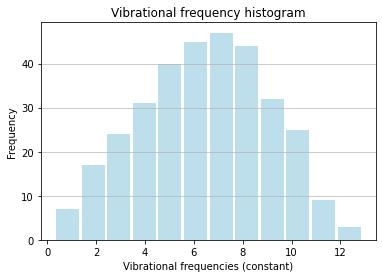

In [16]:
import matplotlib.pyplot as plt
vibList = abs(eigval)**0.5
plt.hist(x=vibList, bins='auto', color='#ADD8E6', alpha=0.8, rwidth=0.9)
plt.grid(axis="y", alpha = 0.8)
plt.title("Vibrational frequency histogram")
plt.xlabel("Vibrational frequencies (constant)")
plt.ylabel("Frequency")
plt.show()